<a href="https://colab.research.google.com/github/RashaAlshawi/Sinkhole-Detection-using-ML/blob/main/Deep%20Learning%20Models/Depth_Wise_Searable_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Import Libraries 
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,concatenate,Conv2DTranspose
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import regularizers

import datetime
#import tensorflow_addons as tfa

# Loading Sinkhole Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
X=np.load('/content/drive/MyDrive/Colab Notebooks/sinkholedataset/sinkhole_dataset.npy')

In [25]:
#@title Dataset Normalization 
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [19]:
X_datas=normalize(X)

In [20]:
# Splitting the Dataset into train and validation
# 85% train and validation, 15% for test
samples_train=int((X_datas.shape[0])*0.85)
#samples_test=int(len(X_datas.shape[0])*0.85)

In [21]:
X_train=X_datas[:samples_train]
X_val=X_datas[samples_train:]


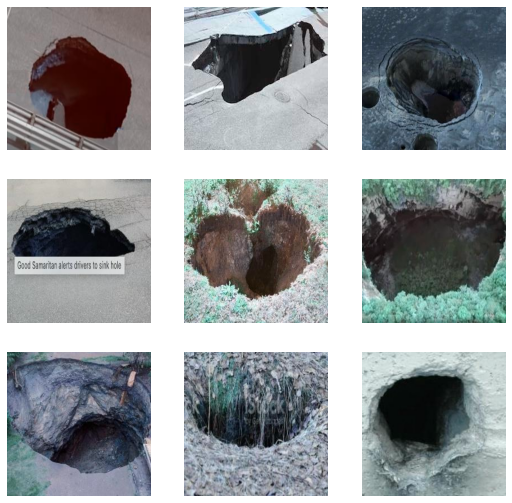

In [26]:
#@title Visualizing samples from Sinkhole Dataset
n_col=3
n_row=3
i=0
plt.figure(figsize=(n_col*3,n_row*3))
for rows in range(n_row):
    for cols in range(n_col):
        index= n_col*rows+cols
        plt.subplot(n_row,n_col,index+1)
        plt.axis('off')
        plt.imshow(X_train[i])
        i+=1
plt.show()
                

## Parameters 

In [ ]:
# Input Dimensions 
IMG_Width=256
IMG_Hight=256
IMG_Channels=3
input_shape=(IMG_Hight,IMG_Width,IMG_Channels)

In [ ]:
activation='relu'
activation2=None
BatchNorm=False
BatchNorm2=False 
learning_rate = 0.001
epochs=200
decay_rate = learning_rate / epochs

In [ ]:
initializer = None#tf.keras.initializers.HeNormal(seed=None)
regularizer=None#regularizers.L1L2(l1=0.4, l2=0.3)

## Metrics

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
opt1=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5)
opt2=tf.keras.optimizers.Adadelta(
  learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta" ) 

## Callbacks

In [ ]:
filepath='/content/drive/MyDrive/Sinkhole_models/my_mode/Autoencoder_Aug'

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# learning rate
def exp_decay(epochs,lr=learning_rate):
    if epochs <20:
       return lr
    else:
        return lr * np.exp(-decay_rate*epochs)

In [ ]:
lr_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)

In [ ]:
my_callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=50),
              tf.keras.callbacks.ModelCheckpoint(
                   filepath,save_best_only=True,monitor='val_loss'),
                  tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]

## Data Augmentation


In [ ]:
#1
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomBrightness(value_range=(0, 1)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3))

    ])

In [ ]:
#2
resize_and_rescale = tf.keras.Sequential([
   tf.keras.layers.RandomBrightness(value_range=(0, 1)),
   #tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomZoom(height_factor=(0.4, 0.3))
   #tf.keras.layers.RandomCrop(0.2, width=0.4)
   #tf.keras.layers.RandomFlip("horizontal")

])


## Depth Wise Separable Autoencoder

In [ ]:
#@title convblock
def convblock(inputs,n_filters,size=3):

  conv=Conv2D(n_filters,(size,size),padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(inputs)
  
  conv=Conv2D(n_filters,(size,size),padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(conv)
  return conv

In [ ]:
def convblock(inputs,n_filters,size=3,activation=activation,batchnormalization=BatchNorm):

  conv=Conv2D(n_filters,(size,size),padding='same')(inputs)
  if batchnormalization==True:
    conv=BatchNormalization()(conv)
  conv=tf.keras.layers.Activation(activation)(conv)
  conv=Conv2D(n_filters,(size,size),padding='same')(conv)
  if batchnormalization==True:
    conv=BatchNormalization()(conv)
  conv=tf.keras.layers.Activation(activation)(conv)
  return conv

In [ ]:
def inception_sepconvblock(inputs,f1,f2,f3):
    "Depth wise Separable Icpetion block"
    conva = SeparableConv2D(f1, (3, 3), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(inputs)
    conva = SeparableConv2D(f1, (3, 3), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(conva)
    
    convb = SeparableConv2D(f2, (5, 5), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(inputs)
    convb = SeparableConv2D(f2, (5, 5), activation=activation, padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(convb)


    convc=MaxPool2D((3,3),strides=(1,1),padding='same')(inputs)
    convc=Conv2D(f3,(1,1),padding='same',kernel_regularizer=regularizer,kernel_initializer=initializer)(convc)
    

    concatenated = concatenate([conva, convb, convc])
  
    return concatenated

In [ ]:
def autoencoder():
  "Depth wise Separable Inception Autoencoder"
  inputs=tf.keras.layers.Input(shape=input_shape)
  # Gaussian Noise Layer 
  inputs=tf.keras.layers.GaussianNoise(stddev=0.9)(inputs)
  # Data Augmentation Layer
  inputs=data_augmentation(inputs)

  #````encoder`````

  conv1=Conv2D(64,(3,3),padding='same')(inputs)

  max1=MaxPool2D((2,2))(conv1)
  conv2=inception_sepconvblock(max1,f1=84,f2=28,f3=16) #128
  max2=MaxPool2D((2,2))(conv2)
  max2=tf.keras.layers.BatchNormalization()(max2)
  conv3=inception_sepconvblock(max2,f1=128,f2=100,f3=28) #256
  max3=MaxPool2D((2,2))(conv3)
  conv4=inception_sepconvblock(max3,f1=256,f2=210,f3=46) #512
  max4=MaxPool2D((2,2))(conv4)

  conv_coding1=Conv2D(32,(3,3),padding='same')(max4)
  max5=MaxPool2D((4,4))(conv_coding1)
  conv_coding2=Conv2D(16,(3,3),padding='same')(max5)


  #````decoder`````
  
  u1=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(conv_coding2)
  
  u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same')(conv_coding1)#(u1)
  #conct1=concatenate([u6,conv4])
  conv_4=inception_sepconvblock(u6,f1=256,f2=210,f3=46)

  u7=Conv2DTranspose(filters=256,kernel_size=(2,2),strides=(2,2),padding='same')(conv_4)
  #conct2=tf.keras.layers.concatenate([u7,conv3])
  conv_3=inception_sepconvblock(u7,f1=128,f2=100,f3=28) #128
  
  u8=Conv2DTranspose(filters=64,kernel_size=(2,2),strides=(2,2),padding='same')(conv_3)
  #conct3=tf.keras.layers.concatenate([u8,conv2])
  conv_2=inception_sepconvblock(u8,f1=84,f2=28,f3=16) #128

  u9=Conv2DTranspose(filters=128,kernel_size=(2,2),strides=(2,2),padding='same')(conv_2)
  #conct4=tf.keras.layers.concatenate([u9,conv1])

  conv_1=Conv2D(64,(3,3),padding='same')(u9)

  output=tf.keras.layers.Conv2D(filters=1,kernel_size=(1,1),activation='sigmoid')(conv_1)
  output=tf.keras.layers.Reshape([256, 256, 1])(output)
  model=tf.keras.Model(inputs=[inputs],outputs=[output])
  return model

In [ ]:
model=autoencoder()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,to_file='model.png')

In [ ]:
# Initializing tensorboard
!kill 674
%tensorboard --logdir logs

In [ ]:
model.compile(optimizer=opt1,loss='binary_crossentropy',metrics=[rounded_accuracy])

In [ ]:
#@title Training the model
history=model.fit(X_train,X_train,epochs=300,validation_split=0.15,batch_size=20,shuffle=True)

## Testing and Evaluating the model

In [ ]:
model.evaluate(X_train,X_train)

In [ ]:
y_predict=model.predict(X_train)

In [ ]:
y_predict=y_predict.reshape((y_predict.shape[0], 256, 256))

In [ ]:
#threshold to convert masks into binary 
y_predict_thr=(y_predict>0.5).astype(np.uint8)

In [ ]:
i=0
print('Sample:',i)
plt.imshow(X_train[i],cmap='gray')
plt.show()
plt.imshow(y_predict_thr[i],cmap='binary')